# Free Diving in Food Facts

The [dataset](https://world.openfoodfacts.org/data) presents many [fields](https://static.openfoodfacts.org/data/data-fields.txt) for each product. 

In [161]:
import re
import pickle
import importlib # reload an imported module 
import itertools
import time
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import json
import folium
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload 
from IPython.display import clear_output

In [2]:
import lucas_utils as lu
# Once the script is imported, calling import will not reload the script if it is modified 
lu = importlib.reload(lu)

In [3]:
# define some constants
DATASET_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'
PICKLE_DATASET_PATH = 'data/en.openfoodfacts.org.products.pickle'

In [4]:
# Pickle utilities
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

**Load the data:**

---
---
Load the whole dataset from the `.csv` file (takes a minute):

In [5]:
chunksize = 100000
tfr = pd.read_csv(DATASET_PATH, encoding=ENCODING, sep='\t', chunksize=chunksize, iterator=True, low_memory=False)
food_facts_df = pd.concat(tfr, ignore_index=True)

In [6]:
# Save the dataframe with pickle for faster loading
save_pickle(food_facts_df, PICKLE_DATASET_PATH)

---
Or use pickle instead to load the dataframe directly:

In [7]:
food_facts_df = load_pickle(PICKLE_DATASET_PATH)

---
---

In [7]:
print('The dataset contains ',len(food_facts_df),' entries.')

The dataset contains  1051145  entries.


**Use a sample of the dataset**

Use only a sample containing 10'000 products for experimenting:

In [8]:
sample_df = food_facts_df.head(10000).copy()

In [9]:
sample_df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question: What are the levels of interdependencies between nations based on their production and importations?

Let us first identify the [fields](https://static.openfoodfacts.org/data/data-fields.txt) that are relevant to the question:

In [10]:
FIELDS = ['origins',
          'origins_tags',
          'manufacturing_places',
          'manufacturing_places_tags',
          'first_packaging_code_geo',
          'cities',
          'cities_tags',
          'purchase_places',
          'stores',
          'countries',
          'countries_tags']
# 'countries_fr' generates a key error

Let us observe the type of information each of them offers: 

In [23]:
def get_field_without_nan(df:pd.DataFrame, field='origins'):
    '''
    Returns a Series of none nan values for the specified "field".
    Specifiy the length of the Series to return with "head". 
    :param df: dataframe to extract info from
    :param field: field of the database to evaluate
    :return: Series, containing all none nan values. 
    '''
    return df[df.notna()[field]][field]

In [24]:
for field in FIELDS:
    print('Field: ' + field)
    field_sr = get_field_without_nan(sample_df,field)
    print('\t',field_sr.head(4).values)

Field: origins
	 ['France' 'Québec' 'Québec' 'France']
Field: origins_tags
	 ['france' 'quebec' 'quebec' 'france']
Field: manufacturing_places
	 ['France' 'France' 'Brossard Québec' 'Brossard Québec']
Field: manufacturing_places_tags
	 ['france' 'france' 'brossard-quebec' 'brossard-quebec']
Field: first_packaging_code_geo
	 ['47.833333,-0.333333' '47.883333,-2.766667' '49.083333,2.75'
 '47.7,-0.366667']
Field: cities
	 []
Field: cities_tags
	 ['sable-sur-sarthe-sarthe-france' 'bignan-morbihan-france'
 'lagny-le-sec-oise-france' 'daumeray-maine-et-loire-france']
Field: purchase_places
	 ['France' 'Roissy,France' 'Roissy,France' 'France']
Field: stores
	 ['courte paille' 'Marks & Spencer' 'Marks & Spencer' "Sainsbury's"]
Field: countries
	 ['France' 'France' 'en:es' 'France']
Field: countries_tags
	 ['en:france' 'en:france' 'en:spain' 'en:france']


An important criterion to select reliable fields is how complete the information is per field:

In [25]:
def get_fields_completeness(df:pd.DataFrame, fields:list, verbose=False):
    '''
    Create a barh plot of the levels of non nan values per field. 
    :param df: dataframe to extract info from
    :param fields: fields of the database to evaluate
    :param verbose: show progress
    :return: dict, completeness of each field
    '''
    fields_fill_percentage = {}
    for i,field in enumerate(fields):
        fields_fill_percentage[field] = len(get_field_without_nan(df,field))/len(df) 
        if verbose:
            print('Done [%d/%d]' % (i+1,len(fields)), end='\r')
    return fields_fill_percentage

In [ ]:
# Completeness levels for the full dataset
fields_fill_percentage = get_fields_completeness(food_facts_df,FIELDS,verbose=True)

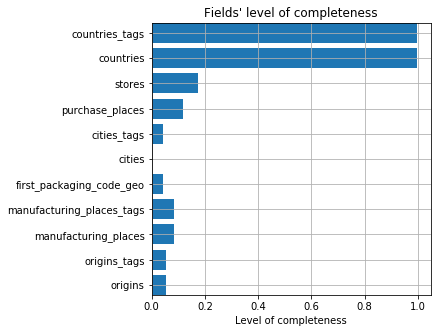

In [28]:
plt.figure(figsize=(5,5))
plt.barh(list(fields_fill_percentage.keys()),list(fields_fill_percentage.values()))
plt.title('Fields\' level of completeness')
plt.xlabel('Level of completeness')
plt.margins(y=0)
plt.grid()

Clearly, the most reliable fields are `countries` and `countries_tags` since they are almost missing no data! Furthermore, `countries_tags` is essentially a cleaned up version of `countries`. We will therefore definitely use this field. It indicates where the product is sold.

Let us analyze this field more in depth. Let us see what `unique()` returns for this field:

In [29]:
# Store unique 'countries_tag' 
unique_countries_tag_s = pd.Series(sample_df['countries_tags'].dropna().unique())

In [30]:
unique_countries_tag_s.head(6)

0            en:france
1             en:spain
2     en:united-states
3           en:ireland
4           en:belgium
5    en:united-kingdom
dtype: object

The data seems to be clean! Some products exist in different countries. When this is the case, the `countries_tag` field contains a list of countries separated by commas. To really identify unique countries the dataframe should be modified to list a single country per product. In this way, we will exactly know what countries are present and how many products are found in each of them.

To do so, we need to explode the `countries_tags` to contain a single value instead of a list of countries. This will create a new row which is a duplicate of the original one where the `countries_tags` field contains a single value. 

In [31]:
def get_unique_values_of_field(df:pd.DataFrame, field='countries_tags', sep=','): 
    '''
    Returns a pd.Series with unique values for the given "field", where the field
    contains multiple values separated by "sep". 

    Procedure (line by line)
    1. Drop nan values from dataset and convert array to a Series.
    2. Split the field's values into list of strings. 
    3. Explode the lists into new rows. 
    4. Reset the index and return the final Series with unique values. 

    :param df: dataframe to extract info from
    :param field: field of the database to evaluate
    :param sep: sperator to split the values 
    '''
    return pd.Series(pd.Series(df[field].dropna().unique())
        .apply(lambda x : str(x).split(sep)) 
        .explode().unique()).sort_values(ascending=True)\
        .reset_index()[0]

In [32]:
unique_countries_sr = get_unique_values_of_field(food_facts_df,field='countries_tags')

In [33]:
# Store the countries in a text file
with open('data/countries.txt','wb') as file: 
    for i,country in enumerate(unique_countries_sr):
        file.write((country+'\n').encode('utf8'))

We also need to know how many products are listed per country, let's have a look:

/home/lucaswaelti/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 33576 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lucaswaelti/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lucaswaelti/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 30476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lucaswaelti/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 33576 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/lucaswaelti/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 22478 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/lucaswaelti/.local/lib/python3.7/site-packages/matplotlib/backends/backen

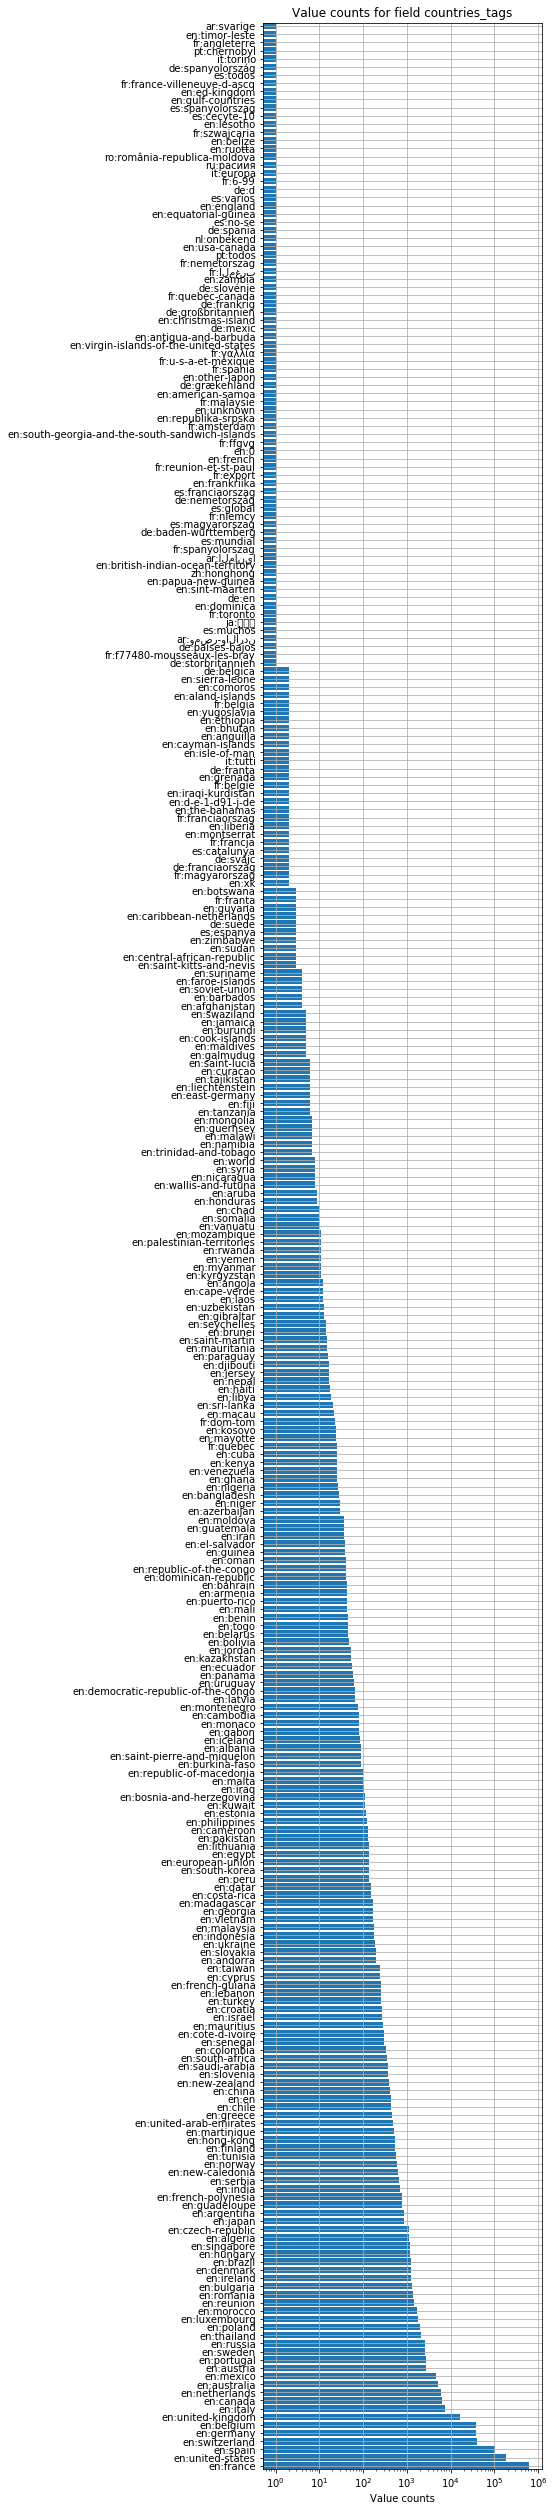

In [34]:
def get_field_value_counts(df:pd.DataFrame, field='countries_tags', sep=','):
    '''
    Count the occurences of the different values of the given "field". 
    The fields containing the specified speratator "sep" are exploded (boom). 

    :param df: dataframe to extract info from
    :param field: field of the database to evaluate
    :param sep: sperator to split the values 
    :return: Series with value count of each value of the 'field'
    '''
    return df[field].dropna().apply(lambda x : str(x).split(sep)).explode().value_counts()

v_counts = get_field_value_counts(food_facts_df,field='countries_tags',sep=',')

plt.figure(figsize=(5,45))
plt.barh(list(v_counts.index),list(v_counts.values))
plt.title('Value counts for field countries_tags')
plt.xlabel("Value counts")
plt.xscale('log')
plt.margins(y=0)
plt.grid()

The previous plot is fine but not really, let us plot the data onto a map to really see where the information is mainly located. 

Let us first read the names of the countries available in the GeoJson file provided by Folium:

In [35]:
# Load the GeoJson file 
world_coutries_geo_path = r'data/world-countries.json'
geo_json_data = json.load(open(world_coutries_geo_path))

Let us make sure the names are all lower case to reduce the risk of mismatch.

In [36]:
# Convert json countries names to lower case and store a seperate list of the names
json_countries = []
for i in range(0,len(geo_json_data['features'])):
    # Modify the JSON object to have lower case country names
    geo_json_data['features'][i]['properties']['name'] = geo_json_data['features'][i]['properties']['name'].lower()
    # Store the names in a separate list
    json_countries.append(geo_json_data['features'][i]['properties']['name'].lower())

We now build a dataframe based on the countries from the json file:

In [37]:
json_countries_df = pd.DataFrame(json_countries).rename(columns={0:'name'})
json_countries_df.head()

,name
0,afghanistan
1,angola
2,albania
3,united arab emirates
4,argentina


We need to build a second DataFrame from the value counts per country from the dataset that we will then merge to the previous dataframe:

In [38]:
# Create a dataframe of the countries count with cleaned up names to match with the json names
countries_counts_df = pd.DataFrame(get_field_value_counts(food_facts_df))\
                        .reset_index().rename(columns={'index':'name','countries_tags':'counts'})

# Remove counts less than 10
countries_counts_df = countries_counts_df[countries_counts_df['counts'] > 10]

# Keep selected prefixes
prefixes = ('en:') # en: english
for pre in prefixes:
    countries_counts_df = countries_counts_df[countries_counts_df['name'].apply(lambda x : pre in str(x))]

# Remove prefixes from name
countries_counts_df['name'] = countries_counts_df['name'].apply(lambda x : re.sub(r'.*:', '', str(x)))\
                                                         .apply(lambda x : re.sub(r'-', ' ', str(x)))
    
countries_counts_df.head()

,name,counts
0,france,624450
1,united states,182255
2,spain,104985
3,switzerland,39505
4,germany,38157


In [39]:
# Create a dictionary to match the most important missing names and replace the required ones
df_to_json_names = {}
df_to_json_names['united states'] = 'united states of america'
df_to_json_names['england'] = 'united kingdom'
df_to_json_names['east germany'] = 'germany'
countries_counts_df['name'] = countries_counts_df['name'].replace(df_to_json_names)

We are now ready to merge `countries_counts_df` into `json_countries_df`:

In [40]:
# Make sure the rows of json_countries_df are not altered
folium_data_df = json_countries_df.merge(countries_counts_df, on=('name'), how='left')
folium_data_df.head(2)

,name,counts
0,afghanistan,NaN
1,angola,12.0


We can finally plot how many products are available per country:

In [41]:
# Folium plot!!!
map_world = folium.Map([30,0], tiles='cartodbpositron', zoom_start=2)
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=folium_data_df,
    columns=['name', 'counts'],
    key_on='feature.properties.name',
    bins=list(np.logspace(0,6.5, 6)),
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of products'
).add_to(map_world)
map_world

In [27]:
with open('world-countries_lower.json', 'w') as file:
    json.dump(geo_json_data,file,separators=(',', ':'), indent=2)

### Products spread across countries

An interesting aspect is to see how products are shared across countries. To observe this, we will identify the different countries each product is selled. 

Based on the `countries_tag` field, we can extract relations between countries. 

In [185]:
# Countries of interest for product relations
selected_countries = ['en:afghanistan','en:albania','en:algeria','en:argentina','en:armenia','en:australia','en:austria',
                      'en:belgium','en:bosnia-and-herzegovina','en:brazil','en:canada','en:croatia','en:cuba','en:czech-republic',
                      'en:east-germany','en:egypt','en:england','en:estonia','en:european-union','en:finland','en:france','en:germany',
                      'en:greece','en:hungary','en:iceland','en:iran','en:iraq','en:ireland','en:israel','en:italy','en:kosovo','en:libya',
                      'en:liechtenstein','en:lithuania','en:luxembourg','en:netherlands','en:norway','en:pakistan','en:poland','en:portugal',
                      'en:russia','en:serbia','en:slovakia','en:slovenia','en:soviet-union','en:spain','en:sweden','en:switzerland','en:syria',
                      'en:turkey','en:ukraine','en:united-states','en:usa-canada']

In [196]:
# Copy the dataset
code_country_df = food_facts_df[['code','countries_tags']].dropna().copy()

# Split the countries tags into lists
code_country_df['countries_tags'] = code_country_df['countries_tags'].apply(lambda x : str(x).split(','))

# Explode the countries (while still promoting peace around the world)
code_country_df = code_country_df.explode('countries_tags').reset_index().drop(columns=['index'])

code_country_df.head(2)

,code,countries_tags
0,0000000000017,en:france
1,0000000000031,en:france


In [197]:
# Only keep desired countries
code_country_df = code_country_df[code_country_df['countries_tags'].apply(lambda x : str(x) in selected_countries)]

In [198]:
# Only keep individual products present in different countries
code_country_df = code_country_df[code_country_df.duplicated('code',keep=False)] # Mark all duplicates as True.

In [199]:
# Store a list of remaining countries with shared products
exchange_countries = code_country_df['countries_tags'].unique()

In [200]:
# Prepare data frame that will be used to plot the relations between countries
grid_exchange_df = pd.DataFrame(0, index=exchange_countries, columns=exchange_countries)
grid_exchange_df.iloc[:2,:2]

,en:france,en:united-states
en:france,0,0
en:united-states,0,0


In [201]:
# Regroup the countries tags 
code_country_df['countries_tags'] = code_country_df['countries_tags'].apply(lambda x : str(x)+',')        # /!\ adds a " " at the end after grouping 
code_country_df = code_country_df.groupby('code').sum()                                                   # Concat the countries tags
code_country_df['countries_tags'] = code_country_df['countries_tags'].apply(lambda x : str(x).split(',')) # Convert countries tags to lists
code_country_df.head(2)

,countries_tags
code,
0000000031141,"[en:france, en:united-states, ]"
0000000034791,"[en:france, en:united-states, ]"


In [204]:
def populate_grid(x):
    '''
    Populate the grid storing the number of common products
    for each pair of countries. 
    '''
    global grid_exchange_df
    for pair in itertools.product(x[:-1], repeat=2):
        grid_exchange_df.loc[pair[0],pair[1]] += 1

In [205]:
# Populate the grid (takes a minute)
code_country_df['countries_tags'].apply(populate_grid)

code
0000000031141             None
0000000034791             None
0000000036252             None
0000000038706             None
0000000039529             None
                          ... 
98437620300               None
9848202407644             None
9848245035378             None
9900014423142000990001    None
9900162792162001950001    None
Name: countries_tags, Length: 58904, dtype: object

In [206]:
grid_exchange_df.iloc[:2,:2]

,en:france,en:united-states
en:france,55679,2006
en:united-states,2006,2481


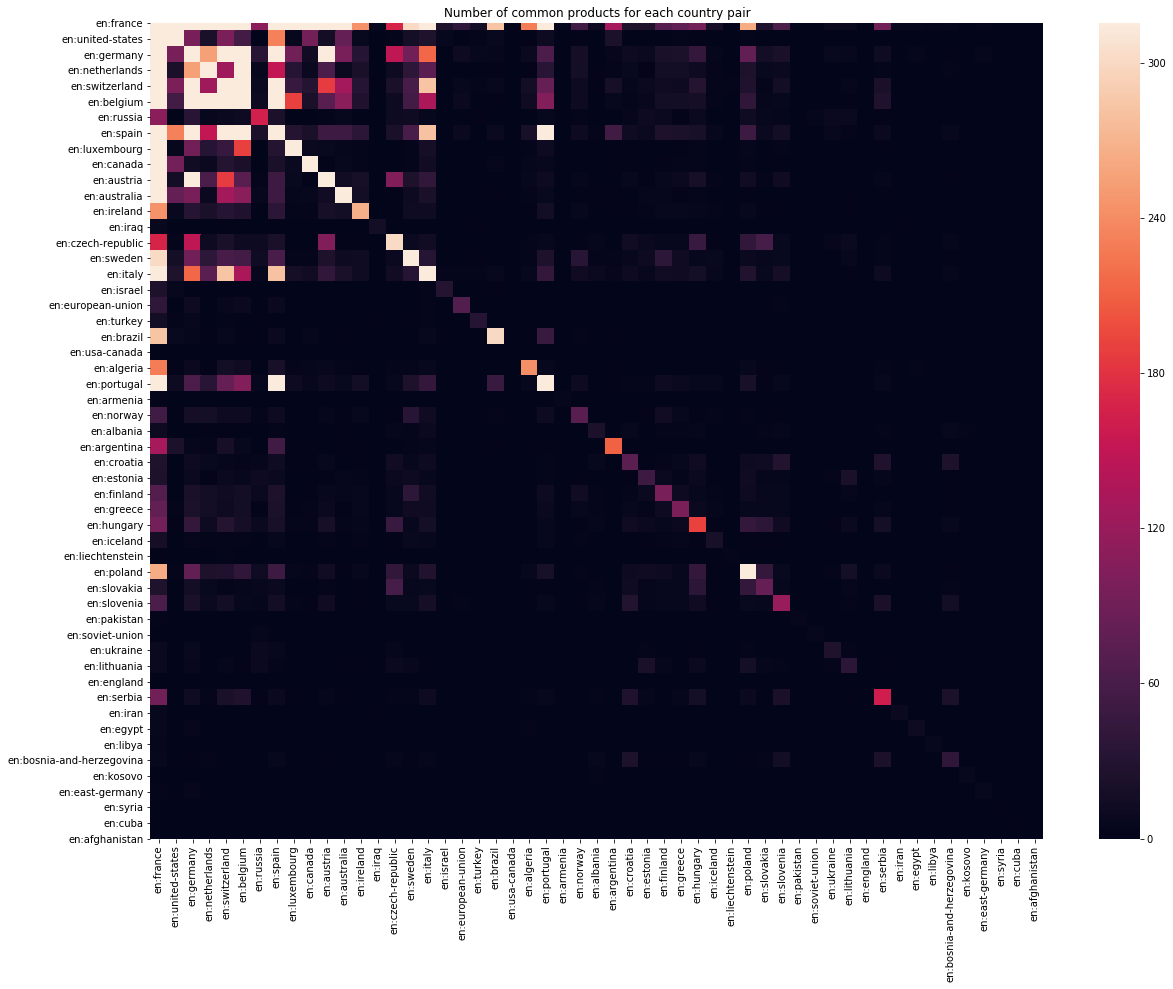

In [209]:
plt.figure(figsize=(20,15))
sns.heatmap(grid_exchange_df, robust=True) # , vmin=0, vmax=60000 
plt.title('Number of common products for each country pair');